In [53]:
import warnings                                  # `do not disturbe` mode
warnings.filterwarnings('ignore')

import numpy as np                               # vectors and matrices
import pandas as pd                              # tables and data manipulations
import matplotlib.pyplot as plt                  # plots
import seaborn as sns                            # more plots

from dateutil.relativedelta import relativedelta # working with dates with style
from scipy.optimize import minimize              # for function minimization

import statsmodels.formula.api as smf            # statistics and econometrics
import statsmodels.tsa.api as smt
import statsmodels.api as sm
import scipy.stats as scs

from itertools import product                    # some useful functions
from tqdm import tqdm_notebook



%matplotlib inline

In [102]:
data = pd.read_excel('./data/день - количество блюд.xlsx', skiprows= 3, usecols= [0,1], names = ['date', 'meals'])
data.head()

,date,meals
0,2018-04-06 00:00:00,32.0
1,2018-04-07 00:00:00,8.0
2,2018-04-08 00:00:00,4.0
3,2018-04-09 00:00:00,14.0
4,2018-04-10 00:00:00,5.0


In [103]:
data.shape

(898, 2)

In [104]:
# remove the last row
data = data.iloc[:-1]

In [105]:
data.tail(5)

,date,meals
892,2020-09-17 00:00:00,136.0
893,2020-09-18 00:00:00,123.0
894,2020-09-19 00:00:00,110.0
895,2020-09-20 00:00:00,120.0
896,2020-09-21 00:00:00,93.0


In [106]:
data['date'] = pd.to_datetime(data['date'])
data.dtypes

date     datetime64[ns]
meals           float64
dtype: object

In [107]:
data = data.set_index('date')
data.head()

,meals
date,
2018-04-06,32.0
2018-04-07,8.0
2018-04-08,4.0
2018-04-09,14.0
2018-04-10,5.0


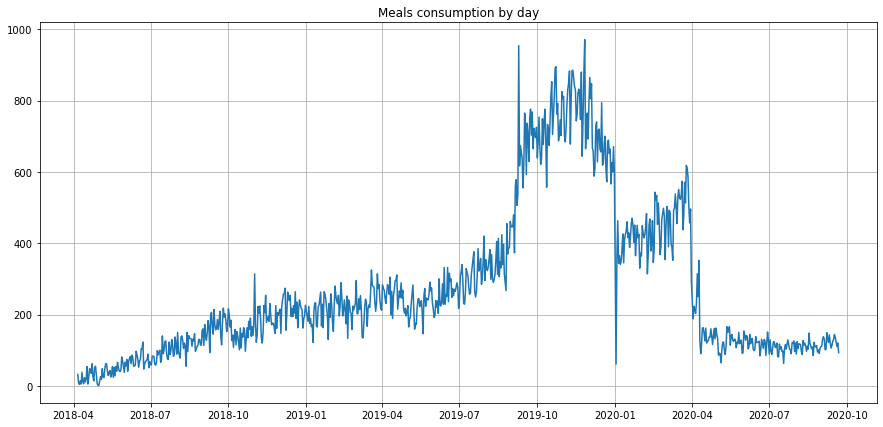

In [109]:
plt.figure(figsize=(15,7))
plt.plot(data.meals)
plt.title('Meals consumption by day')
plt.grid(True)
plt.show()

The nature of the data does not express any periodicity/cyclicity. We can observe a clear drop around 04-2020  due to Covid, but what was the reason for such a spike between 10-2019 and 01-2020.

### Moving Average

In [110]:
from sklearn.metrics import r2_score, median_absolute_error, mean_absolute_error
from sklearn.metrics import median_absolute_error, mean_squared_error, mean_squared_log_error

def mean_absolute_percentage_error(y_true, y_pred): 
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

In [111]:
def moving_average(series, n):
    """
    calculate average of last n observations
    
    """
    return np.average(series[-n:])

In [112]:
moving_average(data.meals, 30)

117.96666666666667

Unfortunately, we cannot make predictions far in the future -- in order to get the value for the next step, we need the previous values to be actually observed. But we can use it to smooth the noisy data.

In [113]:
def plotMovingAverage(series, window, plot_intervals=False, scale=1.96, plot_anomalies=False):
    
    """
        series - df with the data
        window - rolling window size
        plot_intervals - show confidence intervals
        plot_anomalies - show anomalies

    """

    rolling_mean = series.rolling(window=window).mean()
    
    plt.figure(figsize=(15,5))
    plt.title("Moving average with window size = {}".format(window))
    plt.plot(rolling_mean, "g", label = "Rolling mean trend")
    
        # Plot confidence intervals for smoothed values
    if plot_intervals:
        mae = mean_absolute_error(series[window:], rolling_mean[window:])
        deviation = np.std(series[window:] - rolling_mean[window:])
        lower_bond = rolling_mean - (mae + scale * deviation)
        upper_bond = rolling_mean + (mae + scale * deviation)
        plt.plot(upper_bond, "r--", label="Upper Bond / Lower Bond")
        plt.plot(lower_bond, "r--")
        
        # Having the intervals, find abnormal values
        if plot_anomalies:
            anomalies = pd.DataFrame(index=series.index, columns=series.columns)
            anomalies[series<lower_bond] = series[series<lower_bond]
            anomalies[series>upper_bond] = series[series>upper_bond]
            plt.plot(anomalies, "ro", markersize=10)
    
    
    plt.plot(series[window:], label = "Actual values")
    plt.legend(loc="upper left")
    plt.grid(True)

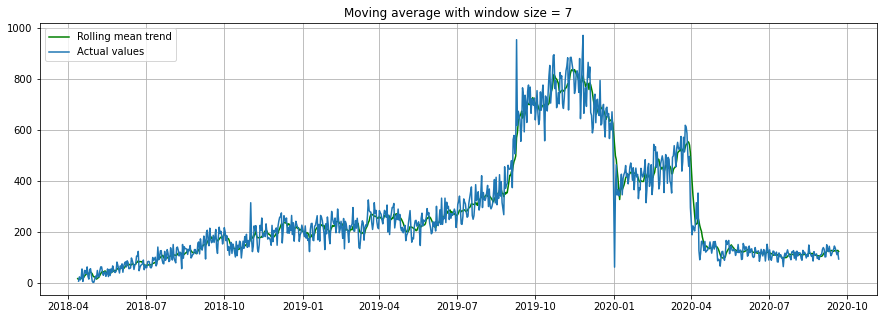

In [123]:
# one week weeek data
plotMovingAverage(data, 7)

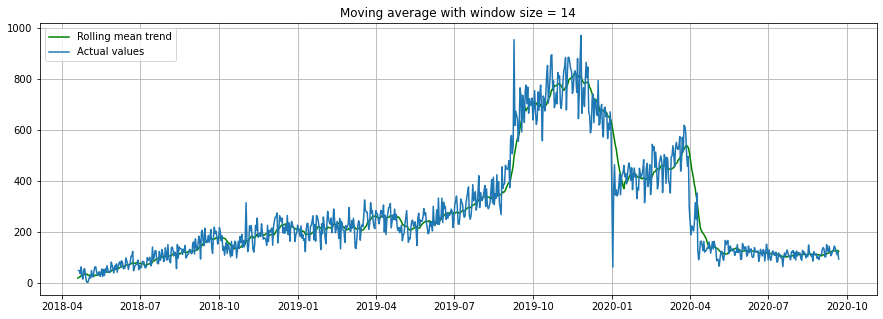

In [124]:
# two weeks window
plotMovingAverage(data, 14)

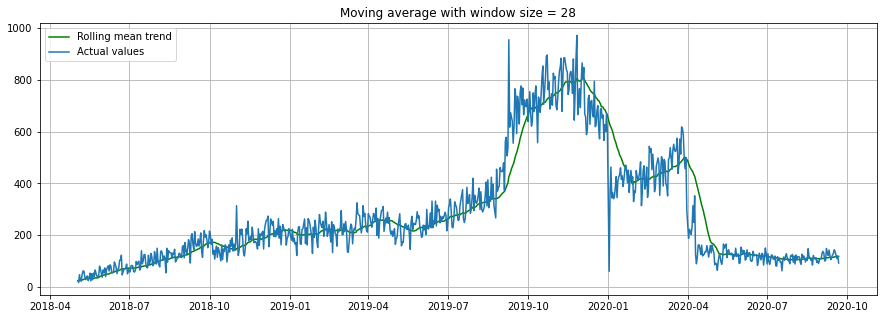

In [121]:
# one month
plotMovingAverage(data, 28)

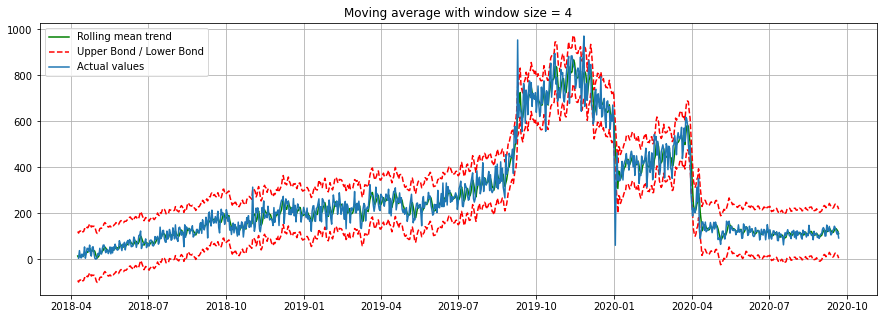

In [122]:
# with confidence interval
plotMovingAverage(data, 4, plot_intervals=True)

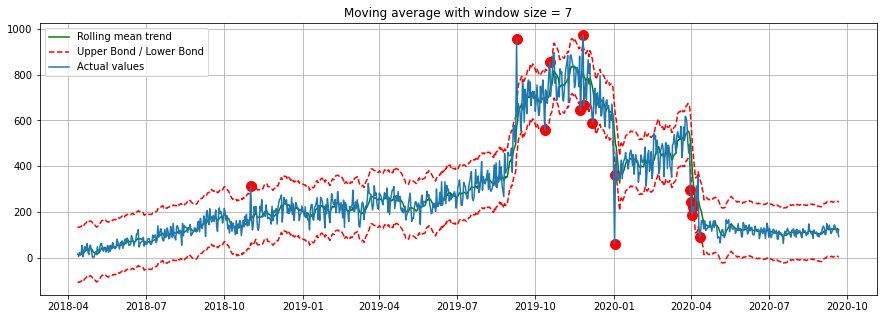

In [125]:
# with anomalies detection
plotMovingAverage(data, 7, plot_intervals=True, plot_anomalies=True)

In [141]:
def anomalies_detector(data, window, scale):
    
    """
        This function will create a df with the anomalies samples.
        data - input time series
        window - window size for moving average
        scale - scale value
    """
    
    rolling_mean = data.rolling(window=window).mean()
    mae = mean_absolute_error(data[window:], rolling_mean[window:])
    deviation = np.std(data[window:] - rolling_mean[window:])
    lower_bond = rolling_mean - (mae + scale * deviation)
    upper_bond = rolling_mean + (mae + scale * deviation)


    anomalies = pd.DataFrame(index=data.index, columns=data.columns)
    anomalies[data<lower_bond] = data[data<lower_bond]
    anomalies[data>upper_bond] = data[data>upper_bond]
    
    anomalies = anomalies[anomalies['meals'].notnull()]
    
    return anomalies



In [142]:
anomalies = anomalies_detector(data, 7, scale=1.96)
anomalies

,meals
date,
2018-11-01,314
2019-09-09,954
2019-10-12,557
2019-10-18,853
2019-11-23,644
2019-11-26,971
2019-11-27,665
2019-12-07,588
2020-01-02,61


### Weighted Average

In [143]:
def weighted_average(data, weights):
    """
        Calculate weighted average on series
    """
    results = 0.0
    weights.reverse()
    for n in range(len(weights)):
        results += data.iloc[-n-1] * weights[n]
    return float(results)

In [144]:
weighted_average(data, [0.6, 0.3, 0.1])

111.3

### Exponential smoothing

In [166]:
def exponential_smoothing(series, alpha):
    
    """
        The idea is that instead of weighting the last  𝑘  values of the time series, we start weighting 
        all available observations while exponentially decreasing the weights as we move further back in time.
        
        series - input data (df with timestemp)
        alpha - smoothing factor, float [0.0, 1.0]
    
    """
    result = [series[0]] # first value is same as series
    for n in range(1, len(series)):
        result.append(alpha * series[n] + (1 - alpha) * result[n-1])
    return result

In [167]:
def plotExponentialSmoothing(series, alphas):
    """
        Plots exponential smoothing with different alphas
        
        series - dataset with timestamps
        alphas - list of floats, smoothing parameters
        
    """
    with plt.style.context('seaborn-white'):    
        plt.figure(figsize=(15, 7))
        for alpha in alphas:
            plt.plot(exponential_smoothing(series, alpha), label="Alpha {}".format(alpha))
        plt.plot(series.values, "c", label = "Actual")
        plt.legend(loc="best")
        plt.axis('tight')
        plt.title("Exponential Smoothing")
        plt.grid(True);

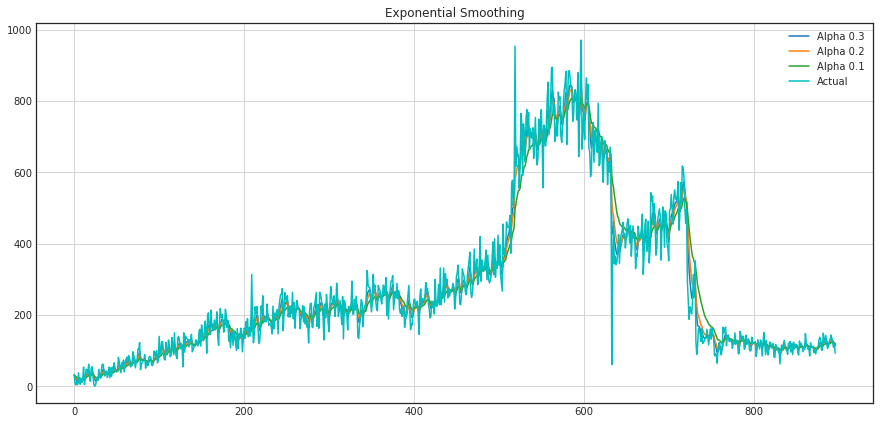

In [172]:
plotExponentialSmoothing(data.meals, [0.3, 0.2, 0.1])

### Double exponential smoothing